In [24]:
import numpy as np
import matplotlib.pyplot as plt

OS = 1 # 1 = MAC; 0 = PC

COLORS_ALL = ["green","blue","green","gold","orangered","orange","yellow","gold","orangered","orange",
              "yellow","gold","orangered","orange","yellow","gold","orangered","orange","yellow","gold",
              "orangered","orange",]
'''
Data class to traverse files to build up a training set

directory: defines where the dataset lives on your local machine
-- Example : "C:\\Users\\mswhi\\GestureDataset\\DHG2016"
-- NOTE    : Set OS variable to define file system
features: string to define which features of the hand to use.
-- OPTIONS : 'all', 'fingertips', 'fingers_palm', 'wrist_palm'
frames: string to define which frames of the dataset to use
-- OPTIONS : 'all', 'first_last', 'first_middle_last', 'middle_only'
-- OPTIONS : trim = If true, trim to start/stop frames; false = entire motion
NUM_ESSAIS, NUM_SUBJECTS, NUM_GESTURES: Do not change if using the DHG2016 database
'''

class Data:
    def __init__(self, directory, features='all', frames='all', trim = True,
                 NUM_ESSAIS = 5, NUM_SUBJECTS = 20, NUM_GESTURES = 14):
        self.directory = directory
        self.NUM_ESSAIS = NUM_ESSAIS
        self.NUM_SUBJECTS = NUM_SUBJECTS
        self.NUM_GESTURES = NUM_GESTURES
        self.features = features
        self.frames = frames
        self.trim = trim
        self.trim_data = []
        
        # Build the y_train array, assuming X_train is ordered by gesture
        self.y_train = np.zeros(NUM_ESSAIS * NUM_SUBJECTS * NUM_GESTURES)
        for i in range(len(self.y_train)):
            self.y_train[i] = int(i / (NUM_SUBJECTS * NUM_ESSAIS) + 1)
        
        # Traverse through the directory to build training data
        
        if self.trim == True :
            self.set_trim()
            
        self.X_train = self.traverse_data()
        
    # Read in the trim data file. The format is:
    #   gesture #
    #   finger #
    #   subject #
    #   essai # (trial #)
    #   frame of the the effective beginning of the gesture
    #   frame of the the effective end of the gesture
    def set_trim(self):
        if OS == 1:
            trim_filename = self.directory + "/informations_troncage_sequences.txt"
        else:
            trim_filename = self.directory + "\\informations_troncage_sequences.txt"
        
        trim_file = open(trim_filename, 'r')
        
        # The trim database has some out-of-order elements so after reading it in, re-sort to fix it.
        for line in trim_file:
            numbers = [int(x) for x in line.split(' ')]
            self.trim_data.append(numbers)
        self.trim_data = sorted(sorted(sorted(sorted(self.trim_data, key = lambda x : x[3]), key = lambda x : x[1]),key = lambda x : x[2]), key = lambda x : x[0])
    
    # Traverse to parse each "skeleton_world.txt" file in the directory
    def traverse_data(self):
        
        trials = []
        for gesture_num in range(1, self.NUM_GESTURES + 1):
            for subject_num in range(1, self.NUM_SUBJECTS + 1):
                for essai_num in range(1, self.NUM_ESSAIS + 1):
                    
                    if self.trim == True:
                        index = (gesture_num - 1)* 2 * self.NUM_SUBJECTS * self.NUM_ESSAIS \
                            + (subject_num - 1) * 2 * self.NUM_ESSAIS \
                            + essai_num - 1

                        # a quick self-check on the dataset to make sure we're aligned
                        if (gesture_num != self.trim_data[index][0]) or (subject_num != self.trim_data[index][2]) \
                            or (essai_num != self.trim_data[index][3]) :
                            print("Error in truncage file sync: Gesture: ",gesture_num," Subject: ",subject_num," Trial: ",essai_num,
                             "index: ",index,"trim: ",self.trim_data[index])
                                               
                    else:
                        index = 0
                        
                    if OS == 1:
                        trials.append(self.parse_frames(self.directory + "/gesture_" + 
                                                        str(gesture_num) + "/finger_1/subject_" + str(subject_num) + 
                                                        "/essai_" + str(essai_num) + "/skeleton_world.txt",index))
                    else:
                        trials.append(self.parse_frames(self.directory + "\\gesture_" + 
                                                        str(gesture_num) + "\\finger_1\\subject_" + str(subject_num) + 
                                                        "\\essai_" + str(essai_num) + "\\skeleton_world.txt",index))
        return trials
    
    # Entry point to parse a particular file--filtering based on self.frames and self.features
    def parse_frames(self, filename,index):
        file = open(filename, 'r')
        lines = []
        for line in file:
            lines.append(line)
            
        # If trimming is enabled, trim to the start/stop limits defined in the truncation file
        if self.trim == True:
            lines = lines[self.trim_data[index][4]:self.trim_data[index][5]+1]
        else:
            lines = lines[0:len(lines)]                
        
        # Set the 'frames' dimension based on how the data should be sampled
        if self.frames == 'all':
            num_frames = len(lines)
        elif self.frames == 'first_last':
            num_frames = 2
        elif self.frames == 'first_middle_last':
            num_frames = 3
        elif self.frames == 'middle_only':
            num_frames = 1
        
        # Set the 'features' dimension based on how the data should be sampled
        if self.features == 'all':
            num_features = 22
        elif self.features == 'fingertips':
            num_features = 5
        elif self.features == 'wrist_palm':
            num_features = 3
        elif self.features == 'fingers_palm':
            num_features = 6
            
        frames = []
        
        # Add frames in a particular way, depending on the filtering strategy
        if self.frames == 'all':
            for i in range(len(lines)):
                line = lines[i]
                frames.append(self.parse_frame(line))
                
        elif self.frames == 'first_last':
            frames.append(self.parse_frame(lines[0]))
            frames.append(self.parse_frame(lines[len(lines) - 1]))
            
        elif self.frames == 'first_middle_last':
            frames.append(self.parse_frame(lines[0]))
            frames.append(self.parse_frame(lines[int(len(lines) / 2)]))
            frames.append(self.parse_frame(lines[len(lines) - 1]))
            
        elif self.frames == 'middle_only':
            frames.append(self.parse_frame(lines[int(len(lines) / 2)]))
            
        return frames

    # Parse an individual frame (line in a file)
    def parse_frame(self, line):
        numbers = line.split(' ')
        full_frame = np.zeros((22,3))
        
        for j in range(len(numbers)):
            full_frame[int(j / 3)][j % 3] = numbers[j]
        
        # Add features on the hand in a particular way, depending on the filtering strategy
        
        frame = []
        if self.features == 'all':
            for i in range (0,22):
                frame.append([full_frame[i],COLORS_ALL[i]])
            return frame
        
        elif self.features == 'fingertips':
            frame.append([full_frame[5],"orange"])
            frame.append([full_frame[9],"orange"])
            frame.append([full_frame[13],"orange"])
            frame.append([full_frame[17],"orange"])
            frame.append([full_frame[21],"orange"])
            return frame
        
        elif self.features == 'wrist_palm':
            frame.append([full_frame[0],"green"])
            frame.append([full_frame[1],"blue"])
            frame.append([full_frame[2],"green"])
            return frame

        elif self.features == 'fingers_palm':
            frame.append([full_frame[1],"blue"])
            frame.append([full_frame[5],"orange"])
            frame.append([full_frame[9],"orange"])
            frame.append([full_frame[13],"orange"])
            frame.append([full_frame[17],"orange"])
            frame.append([full_frame[21],"orange"])
            return frame
        
        
    # For testing purposes only: display each frame of the first trial
    def display(self,trial):
        f_cnt = 0
        for frame in self.X_train[trial]:
            x_vals = []
            y_vals = []
            clr = []
            for feature in frame:
                x_vals.append(feature[0][0])
                y_vals.append(feature[0][1])
                clr.append(feature[1])
            plt.scatter(x_vals, y_vals,c=clr)
            plt.title("Frame " + str(f_cnt))
            plt.show()
            f_cnt += 1

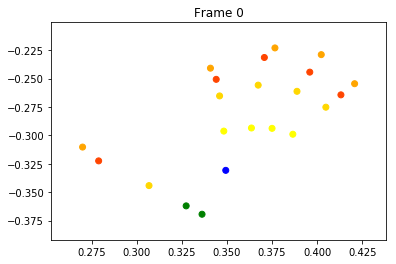

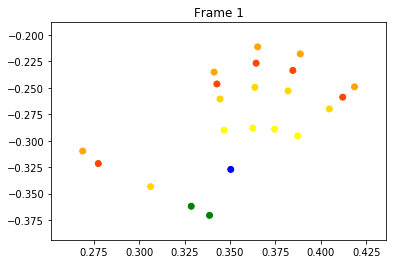

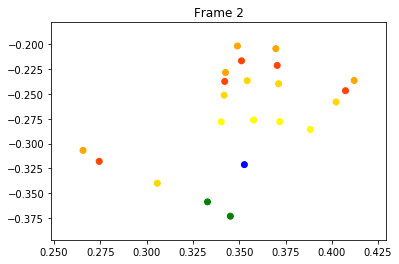

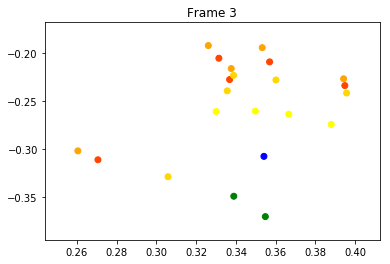

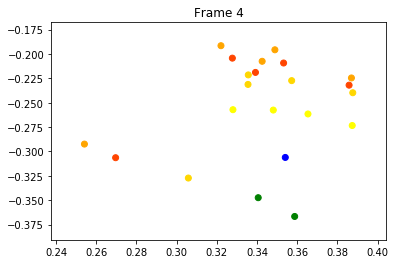

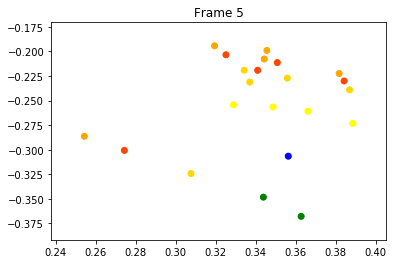

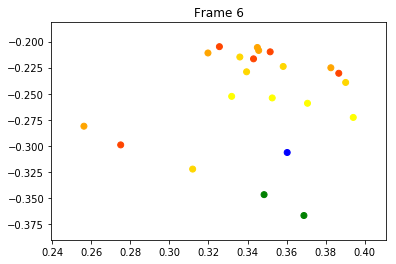

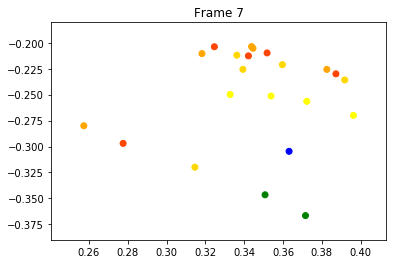

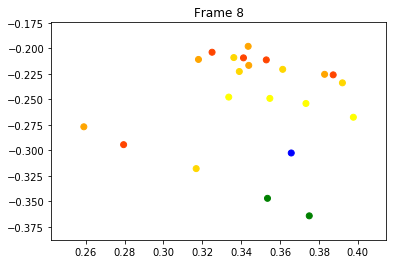

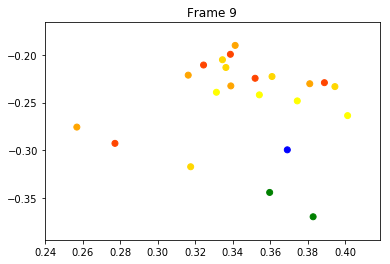

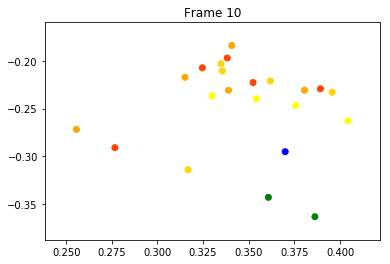

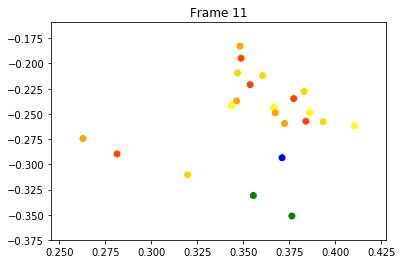

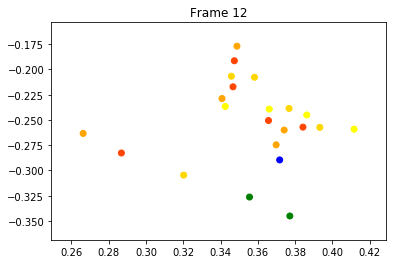

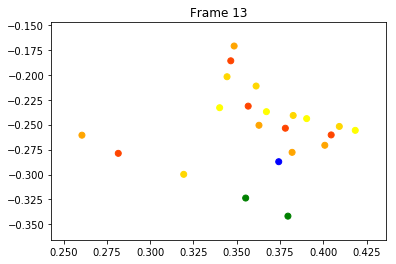

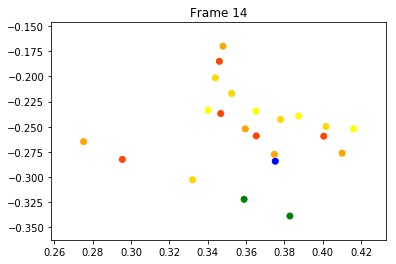

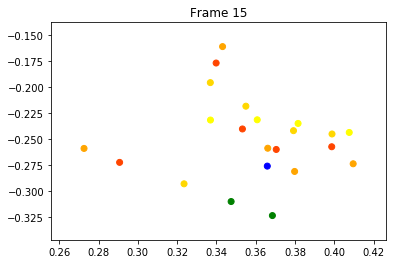

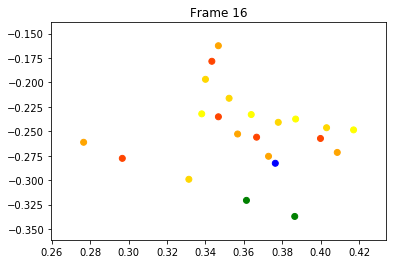

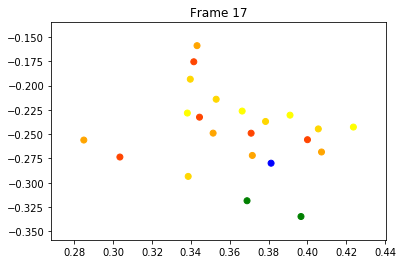

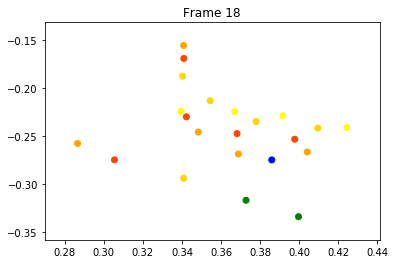

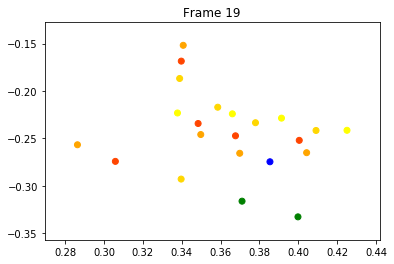

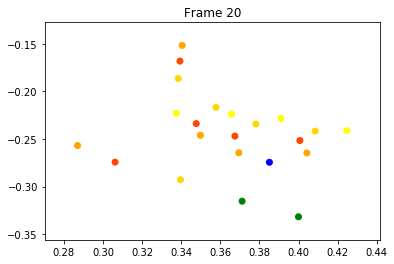

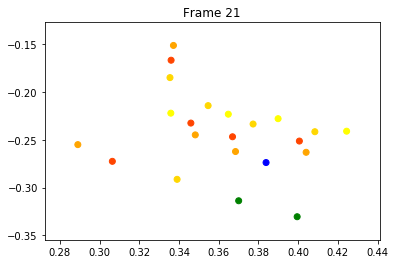

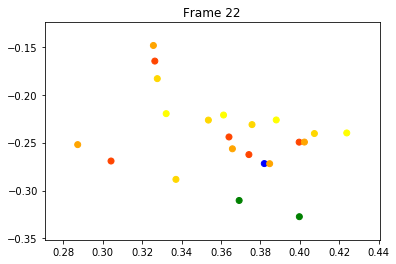

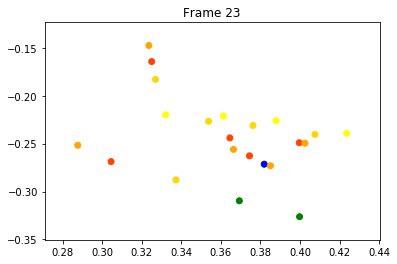

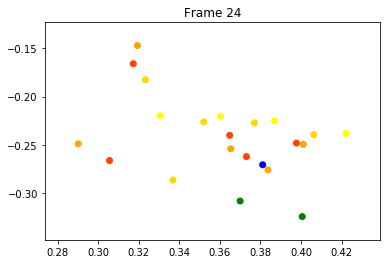

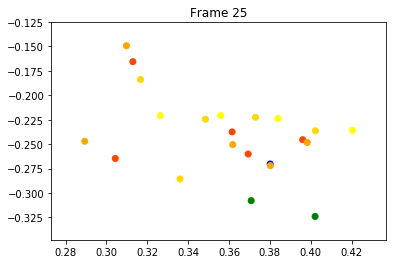

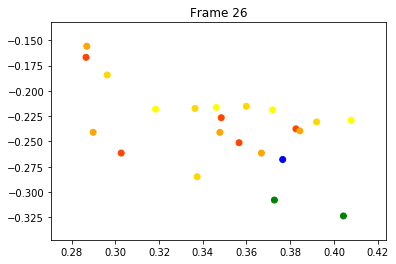

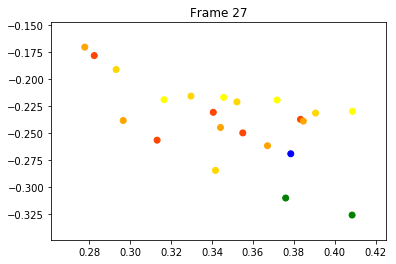

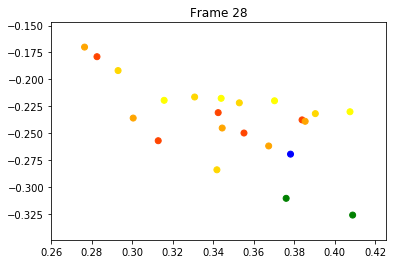

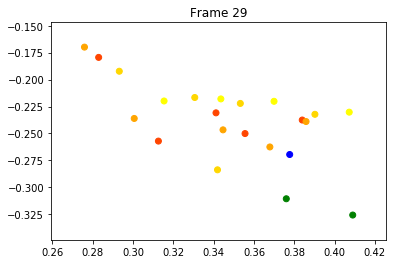

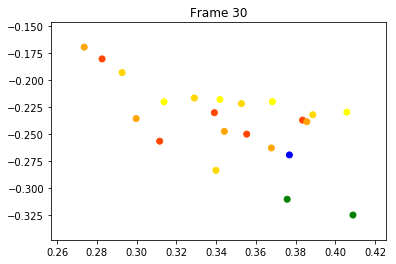

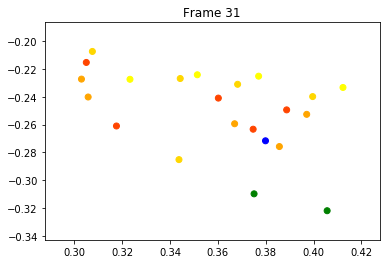

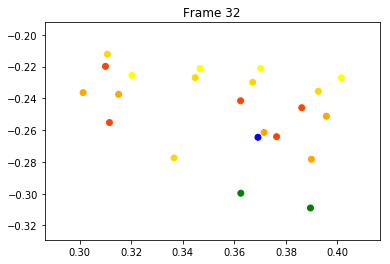

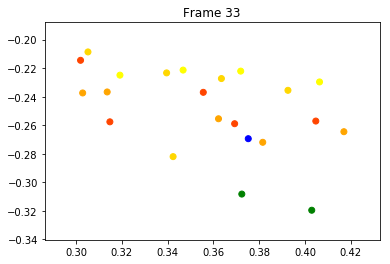

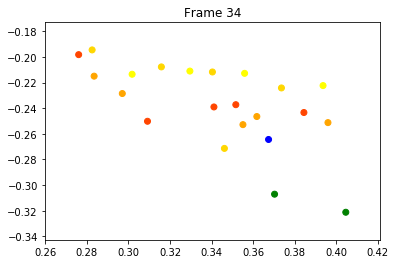

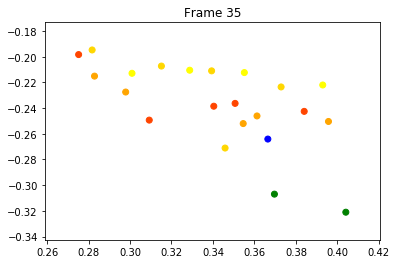

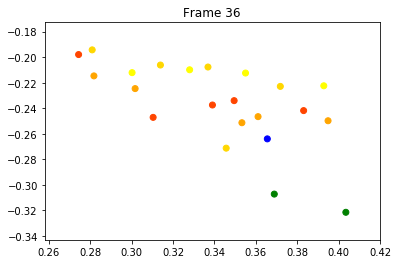

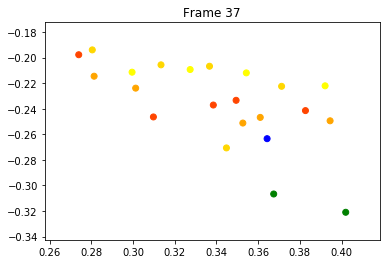

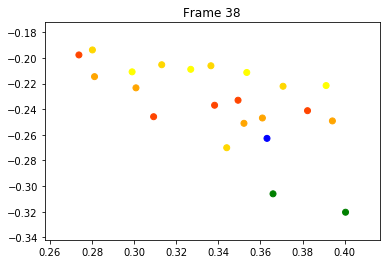

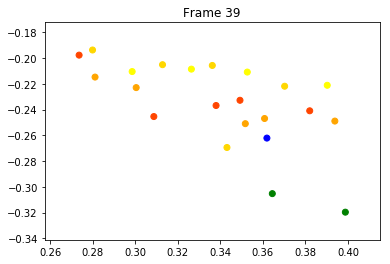

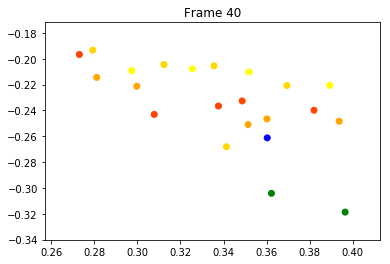

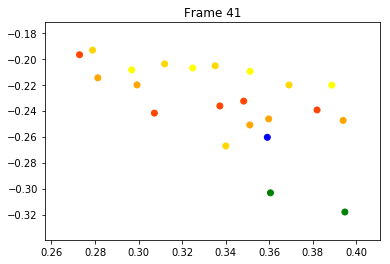

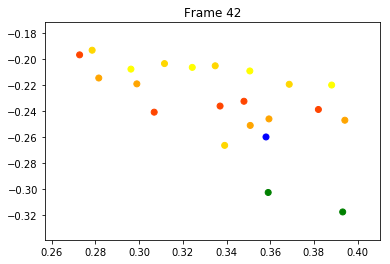

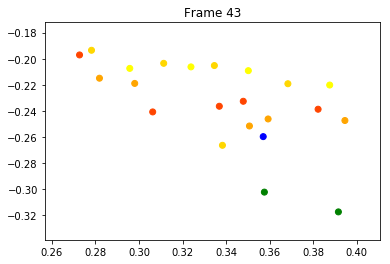

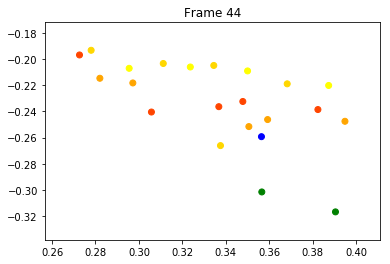

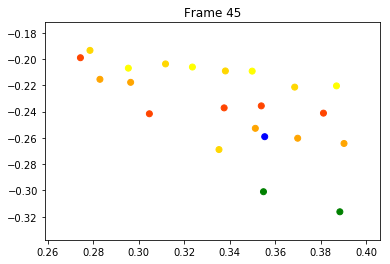

In [25]:
myPath = "/home/jovyan/data"
#myPath = "C:\\Users\\mswhi\\GestureDataset\\DHG2016"

data = Data(myPath, features = 'all', frames='all',trim=True) # Include all data points, all frames
#data = Data(myPath, features = 'fingertips', frames='first_middle_last') # fingertips only, using 3 frames at beginning middle, end of the gesture
#data = Data(myPath, features = 'wrist_palm', frames='middle_only') # wrist and palm points using only the middle frame

data.display(0) # plot (in 2D the first gesture in the training set)